In [1]:
import torch as pt
import torchvision as tv
import os
import numpy as np
import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from GeneticSolver import GeneticSolver

In [2]:
data = np.load('mnist.npz')
X, y = data['X'], data['y']
X_train, X_test, y_train, y_test = train_test_split(X / 255., y, test_size=.2, random_state=42)
X_train = pt.Tensor(X_train).unsqueeze(1)
y_train = pt.Tensor(y_train).long()
X_test = pt.Tensor(X_test).unsqueeze(1)
y_test = pt.Tensor(y_test).long()
train_loader = pt.utils.data.DataLoader(pt.utils.data.TensorDataset(X_train, y_train), batch_size=32)
test_loader = pt.utils.data.DataLoader(pt.utils.data.TensorDataset(X_test, y_test), batch_size=32)

In [3]:
class RobustCNN(pt.nn.Module):
    def __init__(self):
        super().__init__()
        self.base_model = pt.nn.Sequential(
        pt.nn.Conv2d(1, 30, 3),
        pt.nn.MaxPool2d(2),
        pt.nn.ReLU(),
        pt.nn.Conv2d(30, 30, 3),
        pt.nn.MaxPool2d(2),
        pt.nn.ReLU(),
        pt.nn.Conv2d(30, 15, 3),
        pt.nn.MaxPool2d(2),
        pt.nn.ReLU(),
        pt.nn.Flatten(),
        pt.nn.Linear(15, 64),
        pt.nn.ReLU(),
        )
        
        self.classification_model = pt.nn.Sequential(self.base_model, pt.nn.Linear(64, 10), pt.nn.Softmax())
        self.adversary_model = pt.nn.Sequential(self.base_model, pt.nn.Linear(64, 1), pt.nn.Sigmoid())
    
    def fit_hierarchy(self, X):
        adv_indicator = self.adversary_model(X)
        is_real = adv_indicator < .5
        if is_real.any():
            classes = self.classification_model(X[is_real].unsqueeze(1))
        else:
            classes = pt.Tensor()
        return classes, adv_indicator
    
    def predict(self, X):
        return self.classification_model(X), self.adversary_model(X)

model = RobustCNN()
classification_optimizer = pt.optim.Adam(model.classification_model.parameters())
classification_loss = pt.nn.CrossEntropyLoss()
adversary_optimizer = pt.optim.Adam(model.adversary_model.parameters())
adversary_loss = pt.nn.BCELoss()

In [4]:
n_epochs = 5
for epoch in range(n_epochs):
    for Xt, yt in tqdm.tqdm(train_loader):
        classification_optimizer.zero_grad()
        adversary_optimizer.zero_grad()

        X_adv = pt.rand_like(Xt)
        X_input = pt.cat([Xt, X_adv])
        y_input = pt.cat([yt, pt.full_like(yt, -1)])

        adv_target = pt.cat([pt.zeros_like(yt), pt.ones_like(yt)])

        shuffle_idx = pt.randperm(len(X_input))

        X_shuffled = X_input[shuffle_idx]
        y_shuffled = y_input[shuffle_idx]
        adv_shuffled = adv_target[shuffle_idx]
        clf_pred, adv_pred = model.fit_hierarchy(X_shuffled)
        L1 = adversary_loss(adv_pred.squeeze(), adv_shuffled.float())
        L1.backward()
        
        considered_real = adv_pred < .5
        if considered_real.any():
            mostly_real = considered_real.squeeze()
            
            y_cons_real = y_shuffled[mostly_real]
            
            y_pred_idx = y_cons_real != -1
            y_test_idx = mostly_real & (y_shuffled != -1)
            
            L2 = classification_loss(clf_pred[y_pred_idx], y_shuffled[y_test_idx])
            L2.backward()
            classification_optimizer.step()
        adversary_optimizer.step()
    

  0%|          | 0/1500 [00:00<?, ?it/s]/home/ptyshevskyi/envs/loc_env/lib/python3.6/site-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
100%|██████████| 1500/1500 [01:38<00:00, 15.19it/s]


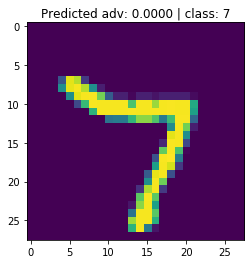

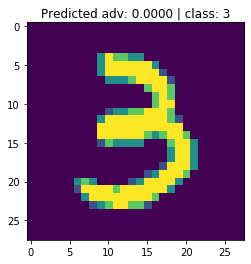

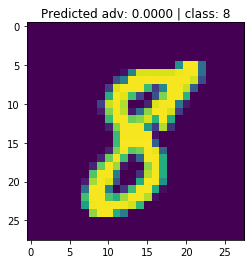

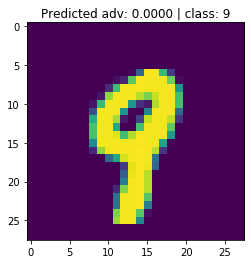

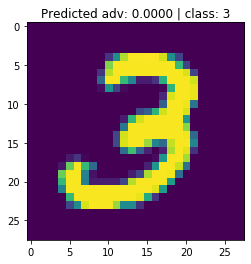

In [5]:
top_n = 5
first_n_pred, adv_ind = model.predict(X_test[:top_n])
cls = first_n_pred.argmax(1)
for i in range(top_n):
    x = X_test[i].squeeze()
    plt.imshow(x)
    plt.title(f'Predicted adv: {adv_ind[i].item():.4f} | class: {cls[i]}');
    plt.axis('off')
    plt.show()

In [25]:
def robust_visualize(adversary_example, adversary_score):
    y_pred, is_adv = model.predict(pt.Tensor(adversary_example).unsqueeze(0).unsqueeze(1))
    assert np.isclose(y_pred.sum().item(), 1)
    target_prob = y_pred[0][adv_target].item()
    plt.figure(figsize=(6, 6))
    plt.imshow(adversary_example, cmap=plt.cm.Greys_r);
    plt.axis('off')
    plt.title(f"P(Adversary)={is_adv.item():.4f}|P(X={adv_target})={target_prob:.4f}|Fitness={adversary_score:.4f}");

In [26]:
def fitness_adversary_detection(X):
    """ X - np.array"""
    y, is_adv = model.predict(pt.Tensor(X).unsqueeze(1))
    y = y.detach().numpy()
    is_adv = is_adv.detach().numpy().squeeze()
    return 1 - is_adv

Generation #: best score
Early stopping on generation  111  with best score  0.9999907


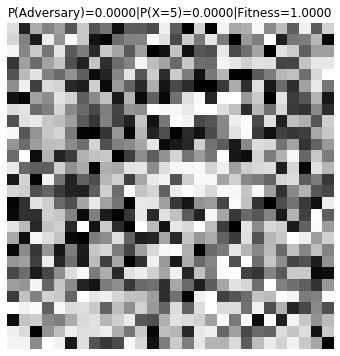

In [27]:
adv_target = 5
m = GeneticSolver(image_size=(28, 28), verbosity=True, verbose_step=250, warm_start=True)
image, score = m.solve(fitness_adversary_detection, n_generations=3000, verbose_step=500)

robust_visualize(image, score)

In [28]:
def fitness_adversary_class(X):
    """ X - np.array"""
    y, is_adv = model.predict(pt.Tensor(X).unsqueeze(1))
    y = y.detach().numpy()
    y_target = y[:, adv_target]
    return y_target

/home/ptyshevskyi/envs/loc_env/lib/python3.6/site-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Generation #: best score
Early stopping on generation  156  with best score  0.99999416


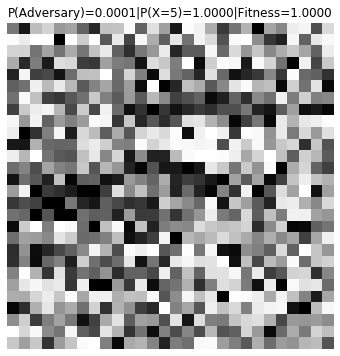

In [31]:
adv_target = 5
m = GeneticSolver(image_size=(28, 28), verbosity=True, verbose_step=250, warm_start=True, patience=200)
image, score = m.solve(fitness_adversary_class, n_generations=3000, verbose_step=500)
robust_visualize(image, score)

In [32]:
def fitness_adversary_class_detection(X):
    """ X - np.array"""
    y, is_adv = model.predict(pt.Tensor(X).unsqueeze(1))
    y = y.detach().numpy()
    is_adv = is_adv.detach().numpy().squeeze()

    return y[:, adv_target] - is_adv

Generation #: best score
Early stopping on generation  333  with best score  0.99999034


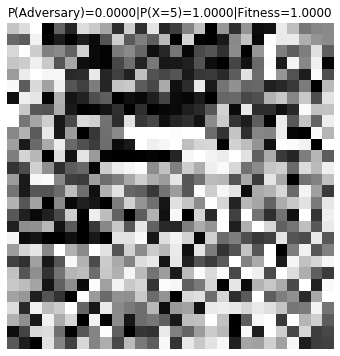

In [34]:
adv_target = 5
m = GeneticSolver(image_size=(28, 28), verbosity=True, verbose_step=250, warm_start=True, patience=200)
image, score = m.solve(fitness_adversary_class_detection, n_generations=3000, verbose_step=500)
robust_visualize(image, score)

In [35]:
def fitness_adversary_similarity(X):
    """ X - np.array"""
    y, is_adv = model.predict(pt.Tensor(X).unsqueeze(1))
    y = y.detach().numpy()
    is_adv = is_adv.detach().numpy().squeeze()
    mse = np.power(X - adv_sample, 2).mean(axis=1).mean(axis=1) ** .5

    return y[:, adv_target] - is_adv - mse

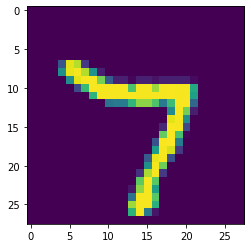

In [36]:
plt.imshow(X_test[0].squeeze());

Generation #: best score
Generation  500 :  0.7315592654361206
Generation  1000 :  0.8165843757952973
Generation  1500 :  0.8606990765213848
Generation  2000 :  0.878188099697205
Generation  2500 :  0.8953635850935349
Generation  2999 :  0.9026985878471198


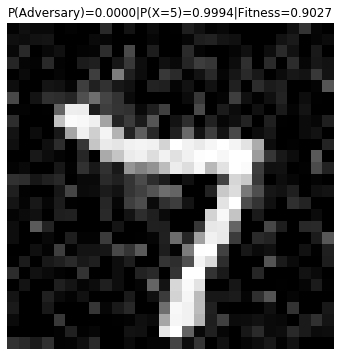

In [39]:
adv_target = 5
adv_sample = X_test[0].numpy()
m = GeneticSolver(image_size=(28, 28), verbosity=True, verbose_step=250, warm_start=True, patience=200)
image, score = m.solve(fitness_adversary_similarity, n_generations=3000, verbose_step=500)
robust_visualize(image, score)